# Regression models to predict Happiness Score

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import objects as so

In [ ]:
df = pd.read_csv('../data/processed/WorldHappiness2015_2022.csv')
df

,Year,Country,Happiness Rank,Happiness Score,Freedom,Generosity,Healthy life expectancy,Perceptions of corruption,GDP per capita,Social support,Dystopia Residual,Region
0,2015,Switzerland,1,7.587,0.66557,0.29678,0.94143,0.41978,1.39651,1.422681,2.51738,Western Europe
1,2015,Iceland,2,7.561,0.62877,0.43630,0.94784,0.14145,1.30232,1.461513,2.70201,Western Europe
2,2015,Denmark,3,7.527,0.64938,0.34139,0.87464,0.48357,1.32548,1.403490,2.49204,Western Europe
3,2015,Norway,4,7.522,0.66973,0.34699,0.88521,0.36503,1.45900,1.401235,2.46531,Western Europe
4,2015,Canada,5,7.427,0.63297,0.45811,0.90563,0.32957,1.32629,1.340878,2.45176,North America
...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2022,Botswana,142,3.471,0.57100,0.01200,0.28000,0.10200,1.50300,0.815000,0.18700,Sub-Saharan Africa
1226,2022,Rwanda,143,3.268,0.62100,0.18700,0.46200,0.54400,0.78500,0.133000,0.53600,Sub-Saharan Africa
1227,2022,Zimbabwe,144,2.995,0.32900,0.10600,0.27000,0.10500,0.94700,0.690000,0.54800,Sub-Saharan Africa
1228,2022,Lebanon,145,2.955,0.10300,0.08200,0.63100,0.03400,1.39200,0.498000,0.21600,Middle East and Northern Africa


In [ ]:
df['Country'] = df['Country'].astype('category')
df['Region'] = df['Region'].astype('category')

In [ ]:
from sklearn.model_selection import train_test_split

# Cross Validation for Happiness Score
X = df.drop('Happiness Score', axis=1)
y = df['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Metrics

Common evaluation metrics for regression problems:

- Mean Absolute Error (MAE) is the mean of the absolute value of the errors: 1n∑i=1n|yi−y^i|
- Mean Squared Error (MSE) is the mean of the squared errors: 1n∑i=1n(yi−y^i)^2
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors: 1n∑i=1n(yi−y^i)^2
 
Comparing these metrics:

- MAE is the easiest to understand, because it's the average error.
- MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are loss functions, because we want to minimize them.

Cross Validation

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate(model, true, predicted):
    return {
        'mae': metrics.mean_absolute_error(true, predicted), 
        'mse': metrics.mean_squared_error(true, predicted), 
        'rmse': np.sqrt(metrics.mean_squared_error(true, predicted)), 
        'r2_square': metrics.r2_score(true, predicted),
        'cross_val' : cross_val_score(model, X, y, cv=10).mean()
    }

In [ ]:
# Graph
def graph(real, predicted):
    X = list(range(0, len(real)))
    df1 = pd.DataFrame(data={
        "X": X,
        "y":real,
        "origin":'real'
    })
    df2 = pd.DataFrame(data={
        "X": X,
        "y":predicted,
        "origin":'predicted'
    })

    data = pd.concat([df1, df2]).reset_index(drop=True)

    return (
        so.Plot(data=data, x='X', y='y', color='origin', marker="origin")
        .add(so.Dots())
        .scale(
            color=['#87b7e0', '#cf604a'],
            marker=so.Nominal(["o", "x"]),
        )
    )

### Transformers

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_selector as selector

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

preprocessor_cat = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regression = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

linear_regression.fit(X_train, y_train)
# linear_regression.score(X_test, y_test)

# evaluate
test_pred = linear_regression.predict(X_test)
evaluate(linear_regression, y_test, test_pred)

{'mae': 0.07637718945306791,
 'mse': 0.011255939625523398,
 'rmse': 0.10609401314647023,
 'r2_square': 0.9906895998384289,
 'cross_val': 0.9875823927069106}

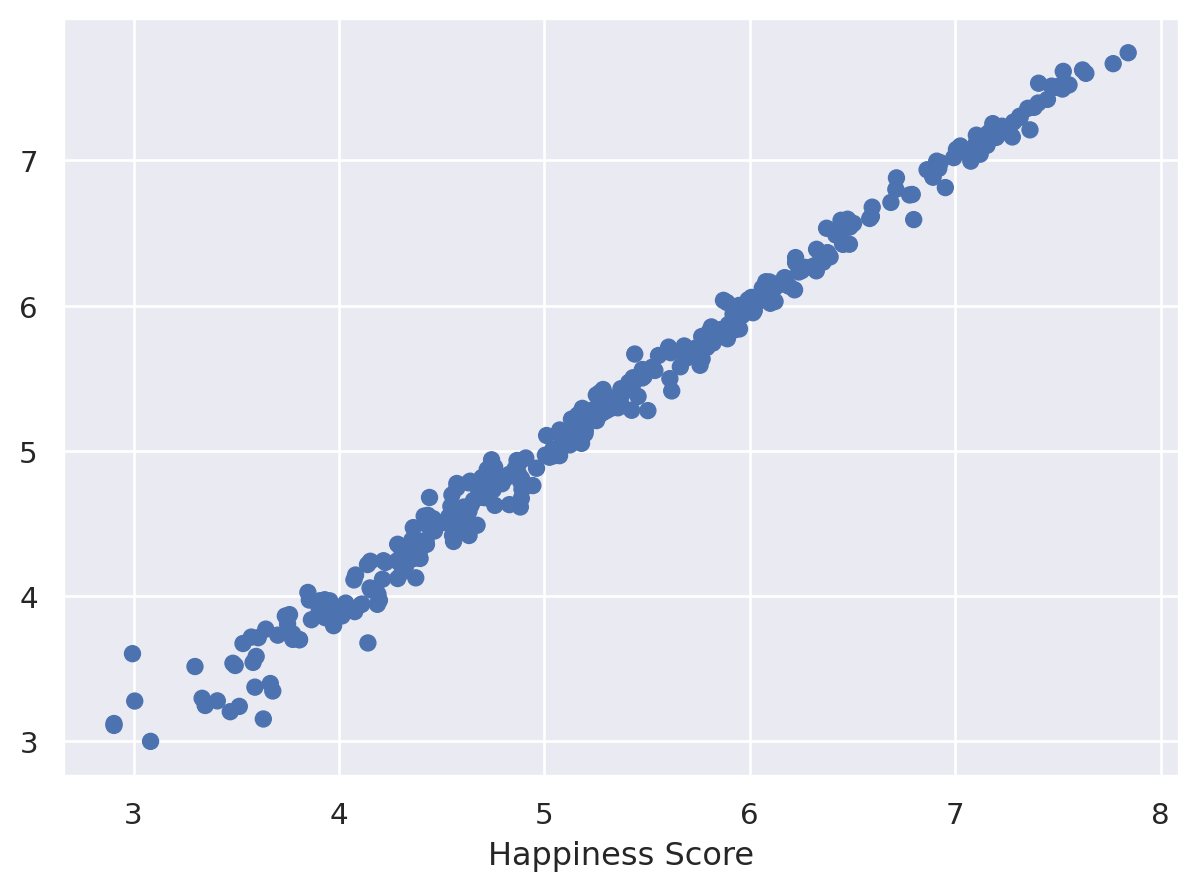

In [ ]:
(
    so.Plot(x=y_test, y=test_pred)
    .add(so.Dot())
)

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", Ridge(alpha=100, solver='auto', tol=0.0001, random_state=42))]
)

ridge_regression.fit(X_train, y_train)
# ridge_regression.score(X_test, y_test)

# evaluate
test_pred = ridge_regression.predict(X_test)
evaluate(ridge_regression, y_test, test_pred)

{'mae': 0.6182467889593949,
 'mse': 0.5909679461199013,
 'rmse': 0.7687443958299152,
 'r2_square': 0.5111782539627628,
 'cross_val': 0.5047324180749324}

### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

lasso_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=42))]
    )

lasso_regression.fit(X_train, y_train)
# lasso_regression.score(X_test, y_test)

# evaluate
test_pred = lasso_regression.predict(X_test)
evaluate(lasso_regression, y_test, test_pred)

{'mae': 0.847885379489352,
 'mse': 1.0243305705635661,
 'rmse': 1.0120921749344602,
 'r2_square': 0.15272044565237408,
 'cross_val': 0.11557259874917176}

### Polynomial Regression

### Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

sgrad_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000))]
    )

sgrad_regression.fit(X_train, y_train)
# sgrad_regression.score(X_test, y_test)

# evaluate
test_pred = sgrad_regression.predict(X_test)
evaluate(sgrad_regression, y_test, test_pred)

{'mae': 1.6828775172814814,
 'mse': 4.374387431157172,
 'rmse': 2.0915036292479083,
 'r2_square': -2.6182938786797667,
 'cross_val': -2.5218177800362698}

### SVM

In [ ]:
from sklearn.svm import SVR

svm_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", SVR(kernel='rbf', C=1000000, epsilon=0.001))]
    )

svm_regression.fit(X_train, y_train)
# svm_regression.score(X_test, y_test)

# evaluate
test_pred = svm_regression.predict(X_test)
evaluate(svm_regression, y_test, test_pred)

{'mae': 0.2326890317125201,
 'mse': 0.10194783871078288,
 'rmse': 0.3192927163447091,
 'r2_square': 0.9156733950622482,
 'cross_val': 0.8816521268213495}

### Regression Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regression_tree = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", DecisionTreeRegressor(max_depth=2))]
    )

regression_tree.fit(X_train, y_train)
# regression_tree.score(X_test, y_test)

# evaluate
test_pred = regression_tree.predict(X_test)
evaluate(regression_tree, y_test, test_pred)

{'mae': 0.6218486881531943,
 'mse': 0.5928799324726383,
 'rmse': 0.769986969027813,
 'r2_square': 0.5095967460087687,
 'cross_val': 0.4433258398208387}

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

randforest_regression = Pipeline(
    steps=[("preprocessor", preprocessor_cat), ("regressor", RandomForestRegressor(n_estimators=1000))]
    )

randforest_regression.fit(X_train, y_train)
# randforest_regression.score(X_test, y_test)

# evaluate
test_pred = randforest_regression.predict(X_test)
evaluate(randforest_regression, y_test, test_pred)

{'mae': 0.21822297025776097,
 'mse': 0.0861011423179905,
 'rmse': 0.2934299615206165,
 'r2_square': 0.9287810599542373,
 'cross_val': 0.9012185026023273}

### Neural Networks

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

df2 = df.copy()
df2['Country'] = df2['Country'].astype('category').cat.codes
df2['Region'] = df2['Region'].astype('category').cat.codes

# Cross Validation for Happiness Score
X = df2.drop('Happiness Score', axis=1)
y = df2['Happiness Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train = np.array(X_train).astype('float32')
# X_test = np.array(X_test).astype('float32')
# y_train = np.array(y_train).astype('float32')
# y_test = np.array(y_test).astype('float32')
# x = np.asarray(x)
nn = Sequential()

nn.add(Dense(X_train.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
# nn.add(Dropout(0.2))

nn.add(Dense(64, activation='relu'))
# nn.add(Dropout(0.2))

nn.add(Dense(128, activation='relu'))
# nn.add(Dropout(0.2))

nn.add(Dense(512, activation='relu'))
nn.add(Dropout(0.1))
nn.add(Dense(1))

nn.compile(optimizer=Adam(0.00001), loss='mse')

r = nn.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

test_pred = nn.predict(X_test)
evaluate(nn, y_test, test_pred)


2023-01-17 17:52:57.288289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 17:52:58.556787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 17:52:58.556815: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-17 17:53:01.575775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Epoch 1/100
861/861 [==============================] - 4s 2ms/step - loss: 139.2495 - val_loss: 9.8305
Epoch 2/100
861/861 [==============================] - 2s 2ms/step - loss: 107.6886 - val_loss: 3.1783
Epoch 3/100
861/861 [==============================] - 2s 2ms/step - loss: 86.8536 - val_loss: 5.6175
Epoch 4/100
861/861 [==============================] - 2s 2ms/step - loss: 70.8128 - val_loss: 5.2591
Epoch 5/100
861/861 [==============================] - 2s 2ms/step - loss: 60.6393 - val_loss: 1.0622
Epoch 6/100
861/861 [==============================] - 2s 2ms/step - loss: 55.0105 - val_loss: 0.9743
Epoch 7/100
861/861 [==============================] - 2s 2ms/step - loss: 42.3932 - val_loss: 0.7475
Epoch 8/100
861/861 [==============================] - 2s 3ms/step - loss: 34.4256 - val_loss: 0.5322
Epoch 9/100
861/861 [==============================] - 2s 3ms/step - loss: 28.7299 - val_loss: 1.0284
Epoch 10/100
861/861 [==============================] - 2s 2ms/step - loss: 24.7

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7fd0889f4700> does not.